# Gold Prediction ARIMA-GARCH semi model

Franck Bui Nguyen

email : franck5nguyen@gmail.com

The purpose of this paper is to: 

1) understand the different variable that can affect the gold spot price and the interraction with all other asset classes from commodities to equities and forex

2) Forecast gold spot price on a short term (about 1 month in the future) using several paper research 
* https://www.researchgate.net/publication/324273329_Trading_gold_future_with_ARIMA-GARCH_model <br>
* https://otexts.com/fpp2/


Note : Main languages used are Python, C++ and some R

# Summary
* Correlation studies
* Forecasting using ARIMA(P,D,Q)
* Presentation GARCH(P,Q)
* Forecasting using hybrid ARIMA-GARCH model

# Time Series

## ARIMA Model

$X_t - \alpha_{1} X_{t-1}-...- \alpha_p X_{t-p} = \epsilon_{t} + \theta_1 \epsilon_{t-1} + .... + \theta_q \epsilon_{t-q}$ 

## GARCH Model
Problem with variance, we are using GARCH model to modelise the 2nd moment of a time series

$\sigma^2_t = \alpha_0 + \alpha_1 \epsilon^2_1 + ... + \alpha_q \epsilon^2_{t-q} = \alpha_0 + \sum_{i=1}^q \alpha_i \epsilon_{t-i}^2$

In [70]:
import dataMngt as dtmgt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsParam as stsp
from statsmodels.tsa.seasonal import  seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import warnings;
#warnings.filterwarnings('ignore');#Disable warning

In [71]:
#get gold data from 2006 till now
all = pd.read_csv(r'C:\Coding\Python Project\Stocks\Data\stock.csv',index_col=False)
EQD = all.loc[all.type == 'EQD']
CTY = all.loc[all.type == 'CTY']
FX = all.loc[all.type == 'FX']

#Format table
allFormat = dtmgt.unstackData(all)
EQDFormat = dtmgt.unstackData(EQD,typeList = ['EQD'])
CTYFormat = dtmgt.unstackData(CTY,typeList = ['CTY'])
FXFormat = dtmgt.unstackData(FX,typeList = ['FX'])

First lets have a look at the data

In [72]:
print(all.head())

  type      underlying0 underlying underlying1        date       price
0  CTY  Precious Metals       Gold         XAU  2005-01-03  428.700012
1  CTY  Precious Metals       Gold         XAU  2005-01-04  428.500000
2  CTY  Precious Metals       Gold         XAU  2005-01-05  426.600006
3  CTY  Precious Metals       Gold         XAU  2005-01-06  421.000000
4  CTY  Precious Metals       Gold         XAU  2005-01-07  418.899994


## Correlation 

First lets get an overall look of what the gold spot price looks like from 1st of January 2005 until now

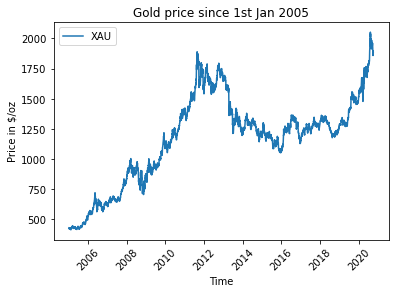

In [73]:
xau = allFormat[['XAU']] #Gold price

sns.lineplot(data=xau)
plt.title("Gold price since 1st Jan 2005")
plt.xlabel('Time')
plt.ylabel('Price in $/oz')
plt.xticks(rotation=45);

# Coronavirus 
The coronavirus hitted financial market around early April 2020 as we can clearly see the deep. During the following month, gold has seen an un-precedented bullish market.

The first reason is that during time of uncertainty, investissors wish to hedge themselves against various factors, for example the power of a money can severely decrease if a country is heated severely by the crisis or hedging against potential volatil underlying asset.

One way to do so is to invest in safe heavens and for ages, gold has proven to be safe and especially in emerging countries.

[]

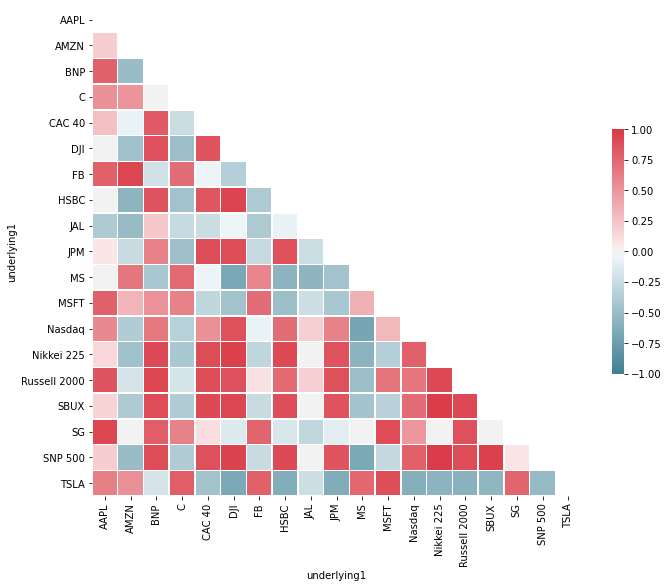

In [74]:
#Calculate correlation between each asset
corrAll, maskALL = stsp.corrParam(allFormat)
corrEQD, maskEQD = stsp.corrParam(EQDFormat)
corrCTY, maskCTY = stsp.corrParam(CTYFormat)
corrFX, maskFX = stsp.corrParam(FXFormat)

f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
stsp.corrPlot(corrEQD,maskEQD)

plt.plot()

30/09/2020


# ARIMA(P,D,Q) Model

It is simpler to study on stationary value, before begining our analysis one question would be, is gold a stationary one? But what is stationary? Lets have a look.

Let $X_t$ be a time series with $t$ the time I am looking at and $X_t$ it's value.

--

**Def : Stationarity**

*Weak*<br>
A time series is stationary in its weak form if its statisics do not vary and are independant from time at each instant it is observed.<br>
For example white noise is stationary

*Strong*<br>
A time series is stationary in its strong form if the density law of $X_t$ at a time t is the same if look at $X_{t+\epsilon}$

That is: $$\forall t \in [0,T], \forall \epsilon > 0$$
$X_t$ is stationary if $\mathcal{L}(X_t) = \mathcal{L}(X_{t+\epsilon}), \forall \epsilon > 0$
<br>
with $\mathcal{L}(X_t)$ the density of X at time t

--

Before jumping heads on the hard stuff, we need to figure out which out of the additive and the multiplicative model is the most accurate. Lets first have a look at the price since 2019-01-01 until now.

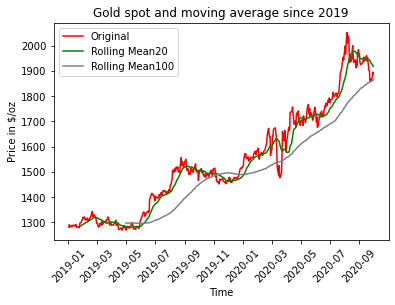

In [75]:
xau = xau[xau.index>="2019-01-01"].dropna() # Filter for 2020 only
rolling_mean20 = xau.XAU.rolling(20).mean()
rolling_mean100 = xau.XAU.rolling(100).mean()

plt.plot(xau, color = 'red', label = 'Original')
plt.plot(rolling_mean20, color = 'green', label = 'Rolling Mean20')
plt.plot(rolling_mean100, color = 'grey', label = 'Rolling Mean100')

plt.legend(loc = 'best')
plt.title('Gold spot and moving average since 2019')
plt.xlabel('Time')
plt.ylabel('Price in $/oz')
plt.xticks(rotation=45);

The above plot represents an overall shape of the gold price since 2019 (closed price). 

Lets break down the time series into its different component 

In [76]:
# xauDecomposition = seasonal_decompose(xau, period=30)
# xauTrend = xauDecomposition.trend
# xauSeasonal = xauDecomposition.seasonal
# xauResidual = xauDecomposition.resid

# #xauDecomposition.plot()
# plt.subplot(411)
# plt.plot(xau,label="Original")
# plt.xticks(rotation=45);
# plt.legend(loc='best')
# plt.subplot(412)

# plt.plot(xauTrend,label="Tendance")
# plt.xticks(rotation=45);
# plt.legend(loc='best')
# plt.subplot(413)

# plt.plot(xauSeasonal,label="Saisonalite")
# plt.xticks(rotation=45);
# plt.legend(loc='best')
# plt.subplot(414)

# plt.plot(xauResidual,label="Residue")
# plt.xticks(rotation=45);
# plt.legend(loc='best')

Without using any mathematics, we can clearly see a tendency throughout time, that is overall the price has been increasing over the months. Moreover if we look closely, both moving average 20 and 100 days keep increasing as time passes by. We can first sniff out that this time series might not be a stationary one.

Lets prove it mathematically with a statistics test using the augmented Dickey Fuller test

--

H0 : Null hypothesis, the time series is not stationary (residual depends from themselves)

H1 : Hypothesis 1, the time series is stationary, independant from himself.

--

Looking at Critical value, 
Test stats < CV10 < CV5 < CV1 < pValue
    On est sur a 99% que la serie est stationnaire
pValue = Proba H0 will not be rejected, si grand : on ne rejete pas donc stationnaire sinon on rejete


In [77]:
stsp.stationary_test(xau)

Results of Dickey-Fuller Test:
Test Statistic                  -0.219530
p-value                          0.936153
No. Lags Used                   10.000000
Number of Observations Used    510.000000
Critical value (1%)             -3.443237
Critical value (5%)             -2.867224
Critical value (10%)            -2.569797
dtype: float64


From the above result, I have a significant p-value which means that the probability to reject incorrectly H0 is high. I thus accept H0 meaning that the time series is **not stationary**. This is what we have already proved just by looking at it but I now prove it mathematicaly.

## Integrated(D)

We now will cover the integration part. We have proven mathematically that the gold is not stationnary. Now what is the next step, We now need to figure out a way to stationarise the data.

Let $\bar{X_t}$ be the transformed time series,

By using the following transform,
$$\bar{X_t} = X_t - X_{t-1}$$

02/10/2020

Stationarize the time series and find its integracy

ACF find 

PACF find

look for density?
not normal density

Use train test

Cross validation?

Forecast

outsampling and insampling?


<AxesSubplot:xlabel='date'>

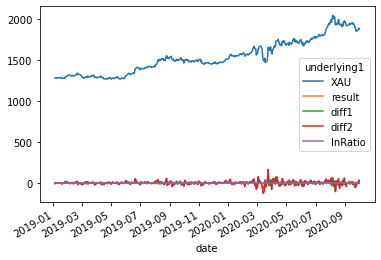

In [78]:
xauTransform = xau.copy()
xauTransform['result'] = xauTransform['XAU'].pct_change()
xauTransform['diff1'] = xauTransform['XAU'].diff(1)
xauTransform['diff2'] = xauTransform['XAU'].diff(2)

xauTransform['lnRatio'] = np.log(xauTransform['XAU'] / xauTransform['XAU'].shift(1))
xauTransform = xauTransform.dropna()
#xauTransform['logResult'] = np.log(xauTransform.result)
#xauTransform.drop(columns='XAU',inplace=True)
xauTransform.plot()




## Variance
$$ \sigma^2 = \frac{\sum^N_{i=1}(x_i-\bar{x})^2}{N-1}$$
<br>
with:<br>
N sample size <br>
N-1 degree of freedom<br>
$\bar x$ mean of the data

# Historical volatility

Annual n day volatility 
$$std(X)_n* \sqrt{252} $$

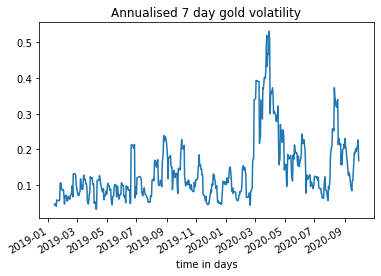

In [79]:
xauTransform['vol'] = xauTransform.XAU.pct_change().rolling(7).std()*(252**0.5)
xauTransform['vol'].plot()
plt.title('Annualised 7 day gold volatility')
plt.xlabel('time in days');

We can seperate the above graph into 2 seperate parts, before 2020-03 and after it. As it shows, at the begining of 20202-03, financial market saw the greatest bear (greater than 2008) ever mainly due to coronavirus that caused lockdown worldwide. Before that day volatility seems constant throughout time.

## Additive vs Multiplicative model
### Additive model 
$$X_t = trend_t + seasonal_t + residual_t$$
$$ X_t - X_{t-1}  = $$


Additive model is useful when the seasonal variation is relatively constant over time

### Multiplicative model 
Multiplicative model is useful when the seaosnal variation increases over time
$$ X_t =trend_t*seasonal_t*error_t$$
$$ ln(X_t) = ln(trend_t)+ln(seasonal_t)+ln(error_t)$$
$$ ln(return) = ln(X_t) - ln(X_{t-1}) = ln(\frac{X_t}{X_{t-1}}) $$

We will first have a look at the additive model.

In [80]:
stsp.stationary_test(xauTransform.diff1)

Results of Dickey-Fuller Test:
Test Statistic                -8.013379e+00
p-value                        2.171166e-12
No. Lags Used                  9.000000e+00
Number of Observations Used    5.090000e+02
Critical value (1%)           -3.443263e+00
Critical value (5%)           -2.867235e+00
Critical value (10%)          -2.569803e+00
dtype: float64


From the above, ADF gives us
$$ tValue < C_1 < C_5 < C_{10} < pValue$$
Time series is stationary ?

We deduce that **D = 1**

## Auto-Regressive(p)

Def : Let $X_t$ be a processus.<br>
$X_t$ is a autoregressive if it can be written as follow
$$ X_t = \sum^p_{i=1}\alpha_i X_{t-i} + \epsilon_t$$
with:<br>
$\epsilon_t$ white noise $\mathcal{N}(0,\mu)$<br>
$\alpha_i$ parameter of the model

## Moving Average(q)

Def : Let $X_t$ be a processus.<br>
$X_t$ is a autoregressive if it can be written as follow
$$ X_t = \sum^p_{i=1}\alpha_i X_{t-i} + \epsilon_t$$
with:<br>
$\epsilon_t$ white noise $\mathcal{N}(0,\mu)$<br>
$\alpha_i$ parameter of the model

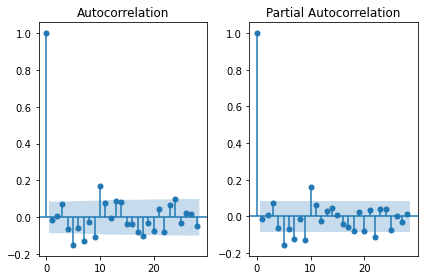

In [81]:
fig, ax = plt.subplots(nrows=1, ncols=2)

plot_acf(xauTransform.diff1,ax=ax[0])

plot_pacf(xauTransform.diff1,ax=ax[1])

plt.tight_layout()
plt.show()

AR(p) = 3 <br>
MA(q) = 3 <br>

To sump so far we have found the ARIMA(3,1,3) model for the gold price

Train test data set

Outsampling and insampling

backtesting


In [82]:
pivotDate = "2020-01-01"
train = xau[xau.index < pivotDate] #Train sample from 2019-01-01 until 2020-01-01
test = xau[xau.index >= pivotDate] #test sample from 2020-01-01 onward

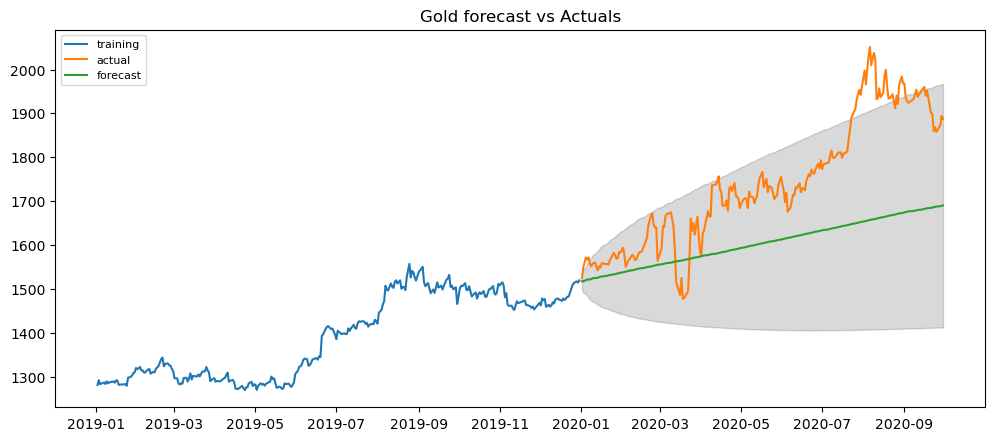

In [83]:
model = ARIMA(train, order=(3,1,3));
fit = model.fit(disp=0);
predict = fit.predict()
sizePredict = len(test)
fc, se, conf = fit.forecast(sizePredict, alpha=0.05)
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series,
                 color='k', alpha=.15)
plt.title('Gold forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()
